In [55]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib as plt
# Library that downloads historical market data from Yahoo! Finance in a Pythonic way since Yahoo! Finance
# decommissioned their historical market data API
import yfinance as yf

In [56]:
# Create a function to get the stock data for a list of symbol(s) with specific start and end dates
## The function automatically puts the data into a DataFrame, concatenates each ticker dataframe together, and
## indexes it by Date then Symbol
def get_stock_data(symbol_list, start=None, end=None):
    output = pd.DataFrame()
    for symbol in symbol_list:
        df = yf.download(symbol, start, end, auto_adjust=True)
        df["Symbol"] = symbol
        df = df.reset_index(["Date"])
        df = df.set_index(["Date", "Symbol"])
        output = pd.concat([output, df], axis=0)
    return output.sort_index()

In [57]:
# Pull the updated stock data from Yahoo! Finance using the yfinance library for our designated time frame
stocks = get_stock_data(["AAPL", "AMZN", "FB", "GOOGL", "MSFT"], start="2014-01-01", end=None)
print(stocks.tail(10))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                          Open         High          Low        Close  \
Date       Symbol                                                       
2019-11-07 AAPL     258.739990   260.350006   258.109985   259.429993   
           AMZN    1803.760010  1805.900024  1783.479980  1788.199951   
           FB       191.910004   193.440002   189.470001   190.419998   
           GOOGL   1294.280029  1322.650024  1293.750000  1306.939941   
           MSFT     143.839996   144.880005   143.770004   144.259995   
2019-11-08 AAPL     258.690002   260.440002   256.850006   260.140015   
           AMZN    1787.890015  1789.880005  1774.040039  1785.880005  

In [58]:
# Create a DataFrame to hold all of our indicators that will be used in our model to predict future stock prices
indicators = pd.DataFrame(index=stocks.index)

# Calculate the ratio of the change in volume from the previous day
indicators["volume_change_ratio"] = stocks.groupby(level="Symbol").Volume.diff(1) / stocks.groupby(level="Symbol")\
                                    .shift(1).Volume
# Calculate the percentage price change in the stock on a rolling 5 day basis
indicators["5_day_momentum"] = stocks.groupby(level="Symbol").Close.pct_change(5)

In [59]:
# 12 day, 26 day, 50 day, and 200 day exponential moving averages
ema_12_day = lambda x: x.ewm(span=12).mean()
ema_26_day = lambda x: x.ewm(span=26).mean()
ema_50_day = lambda x: x.ewm(span=50).mean()
ema_200_day = lambda x: x.ewm(span=200).mean()

# Daily closing price vs. 50 day exponential moving average
indicators["50_day_ema"] = stocks.Close / stocks.Close.groupby(level="Symbol").apply(ema_50_day) - 1
# Daily closing price vs. 200 day exponential moving average
indicators["200_day_ema"] = stocks.Close / stocks.Close.groupby(level="Symbol").apply(ema_200_day) - 1

# The moving average convergence divergence (macd) shows the relationship between the 12 and 26 day exponential moving
# averages by revealing changes in the strength, direction, momentum, and duration of a trend
indicators["macd"] = (stocks.Close / stocks.Close.groupby(level="Symbol").apply(ema_12_day) - 1) - \
                      (stocks.Close / stocks.Close.groupby(level="Symbol").apply(ema_26_day) - 1)

In [60]:
# Volume percentage change over the previous 5 day rolling period
vol_pct_change = lambda x: x.pct_change(5)
indicators["5_day_vol_change"] = stocks.groupby(level="Symbol").Volume.apply(vol_pct_change)

# Intraday percentage change from opening price to closing price each day
indicators["intraday_move"] = (stocks.groupby(level="Symbol").Close.shift(0) - stocks.groupby(level="Symbol").Open
                               .shift(0)) / stocks.groupby(level="Symbol").Open.shift(0)

print(indicators.tail(30))

                   volume_change_ratio  5_day_momentum  50_day_ema  \
Date       Symbol                                                    
2019-11-01 AAPL               0.085966        0.037473    0.120675   
           AMZN               0.003308        0.017095    0.006009   
           FB                -0.486555        0.030497    0.040630   
           GOOGL             -0.096803        0.006288    0.038617   
           MSFT               0.346404        0.021246    0.035324   
2019-11-04 AAPL              -0.316646        0.033929    0.122399   
           AMZN              -0.006630        0.015520    0.012899   
           FB                -0.245972        0.028089    0.044636   
           GOOGL              0.063168        0.000489    0.050614   
           MSFT              -0.489501        0.002497    0.039619   
2019-11-05 AAPL              -0.226338        0.056887    0.115503   
           AMZN              -0.319781        0.022125    0.010798   
           FB       

Date        Symbol
2019-11-06  AAPL      2.610391
            AMZN     -0.070126
            FB        0.847734
            GOOGL     2.040062
            MSFT      1.364961
2019-11-07  AAPL      2.704770
            AMZN     -0.151484
            FB        0.751933
            GOOGL     2.284488
            MSFT      1.371788
2019-11-08  AAPL      2.691248
            AMZN     -0.180733
            FB        0.783048
            GOOGL     2.281599
            MSFT      1.503972
Name: z_score, dtype: float64


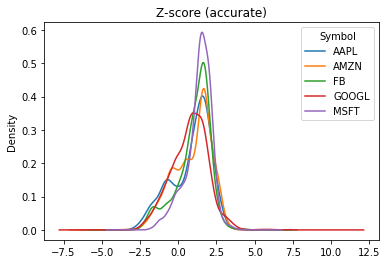

In [68]:
# Use a rolling 200 day window to calculate the z-scores for each ticker
## Use of a specified period prevents the z-score from using the mean and std dev from the entire time period of the data
z_score = lambda x: (x - x.rolling(window=200, min_periods=20).mean()) / x.rolling(window=200, min_periods=20).std()
indicators["z_score"] = stocks.groupby(level="Symbol").Close.apply(z_score)
indicators.z_score.unstack().plot.kde(title='Z-score (accurate)')
print(indicators["z_score"].tail(15))

In [69]:
indicators.columns

Index(['volume_change_ratio', '5_day_momentum', '50_day_ema', '200_day_ema',
       'macd', '5_day_vol_change', 'intraday_move', 'z_score'],
      dtype='object')

In [70]:
# Create a DataFrame to hold the stock price movement predictions
outcomes = pd.DataFrame(index=stocks.index)

# Calcualte the next day, the next 5 day, and the next 20 day percentage change based on closing price
## For the purposes of this model, we will be using these outcomes to predict the directional price change, 
## not necessarily using the prediction as an indication of magnitude of price change
next_day = lambda x: x.pct_change(-1)
next_5_days = lambda x: x.pct_change(-5)
next_20_days = lambda x: x.pct_change(-20)
outcomes["day_1"] = stocks.groupby(level="Symbol").Close.apply(next_day)
outcomes["day_5"] = stocks.groupby(level="Symbol").Close.apply(next_5_days)
outcomes["day_20"] = stocks.groupby(level="Symbol").Close.apply(next_20_days)

print(outcomes.tail(30))

                      day_1     day_5  day_20
Date       Symbol                            
2019-11-01 AAPL   -0.006524 -0.019550     NaN
           AMZN   -0.007326  0.003113     NaN
           FB     -0.005649  0.014567     NaN
           GOOGL  -0.013461 -0.028075     NaN
           MSFT   -0.005742 -0.015347     NaN
2019-11-04 AAPL    0.001439       NaN     NaN
           AMZN    0.001637       NaN     NaN
           FB      0.002058       NaN     NaN
           GOOGL  -0.001417       NaN     NaN
           MSFT    0.000623       NaN     NaN
2019-11-05 AAPL   -0.000428       NaN     NaN
           AMZN    0.003308       NaN     NaN
           FB      0.014461       NaN     NaN
           GOOGL   0.000333       NaN     NaN
           MSFT    0.002777       NaN     NaN
2019-11-06 AAPL   -0.011410       NaN     NaN
           AMZN    0.004233       NaN     NaN
           FB      0.005934       NaN     NaN
           GOOGL  -0.012189       NaN     NaN
           MSFT   -0.001386       

In [71]:
# Identify the X and y variables for the linear regression
X = indicators
y = outcomes.day_5

# Combine X and y into a DataFrame to drop the NaN and infinity values so both variables have the same number of obs
Xy = X.join(y).dropna()
Xy = Xy.replace([np.inf, -np.inf], np.nan).dropna()
y = Xy[y.name]
X = Xy[X.columns]

print(X.shape)
print(y.shape)

(7255, 8)
(7255,)


In [72]:
# Run a linear regression using all of the indicators
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

# Compute the R-Squared and the model coefficients for each indicator
print(f"R-Squared: {model.score(X, y)}")
print(f"Coefficients: ")
print(pd.Series(model.coef_, index=X.columns))

R-Squared: 0.014090981260676982
Coefficients: 
volume_change_ratio    0.000061
5_day_momentum        -0.018844
50_day_ema             0.220769
200_day_ema            0.019722
macd                   0.518030
5_day_vol_change       0.001837
intraday_move          0.016721
z_score               -0.001328
dtype: float64


In [73]:
# Create a variable to hold the quarterly retrain dates
retrain_dates = X.resample("Q", level="Date").mean().index.values[:-1]

# Create the walk forward prediction model using the retrain dates 
models = pd.Series(index=retrain_dates)
for date in retrain_dates:
    X_train = X.xs(slice(None, date), level="Date", drop_level=False)
    y_train = y.xs(slice(None, date), level="Date", drop_level=False)
    model = LinearRegression()
    model.fit(X_train, y_train)
    models.loc[date] = model

start_dates = models.index 
end_dates = models.index[1:].append(pd.to_datetime(["2029-12-31"]))

predictions = pd.Series(index=indicators.index)

# Get the predictions for the model each time it is retrained
for i, model in enumerate(models):
    X = indicators.xs(slice(start_dates[i], end_dates[i]), level="Date", drop_level=False)\
              .replace([np.inf, -np.inf], np.nan).dropna()
    prediction = pd.Series(model.predict(X), index=X.index)
    predictions.loc[X.index] = prediction

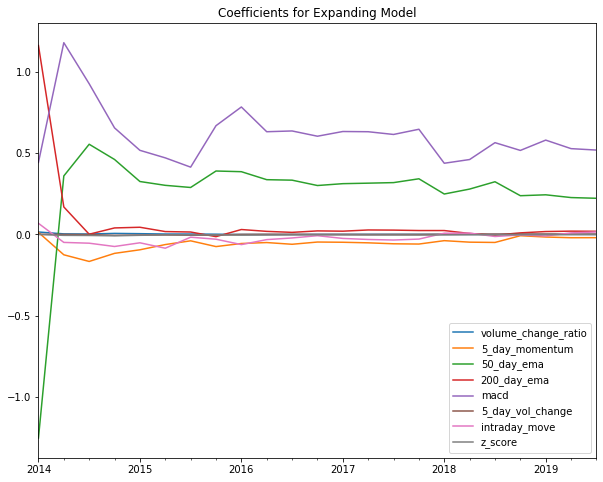

In [74]:
# Create a function to graph a time series of the coefficient values for each of the technical indicators
def extract_coefficients(models):
    coefficients = pd.DataFrame()
    for i, model in enumerate(models):
        ## Grab the coefficients from the linear regression model
        model_coefficients = pd.Series(model.coef_, index=["volume_change_ratio", "5_day_momentum", "50_day_ema", 
                                                           "200_day_ema", "macd", "5_day_vol_change", 
                                                           "intraday_move", "z_score"])
        model_coefficients.name = models.index[i]
        coefficients = pd.concat([coefficients, model_coefficients], axis=1, sort=False)
    return coefficients.T

extract_coefficients(models).plot(title="Coefficients for Expanding Model", figsize=(10, 8))

In [75]:
import sklearn.metrics as metrics

# Get the same number of values for the y_pred and y_actual variables by dropping the NaN values
common_idx = y.dropna().index.intersection(predictions.dropna().index)
y_actual = y[common_idx]
y_actual.name = "y_actual"
y_pred = predictions[common_idx]
y_pred.name = "y_pred"

# Compute the statistical metrics for our model
standard_metrics = pd.Series()

standard_metrics.loc["Explained variance"] = metrics.explained_variance_score(y_actual, y_pred)
standard_metrics.loc["MAE"] = metrics.mean_absolute_error(y_actual, y_pred)
standard_metrics.loc["MSE"] = metrics.mean_squared_error(y_actual, y_pred)
standard_metrics.loc["R-Squared"] = metrics.r2_score(y_actual, y_pred)

print(standard_metrics)

Explained variance   -0.038273
MAE                   0.026076
MSE                   0.001299
R-Squared            -0.038560
dtype: float64


In [76]:
# Create a function to create a DataFrame with our y_pred and y_actual values as well as add columns to show whether
# the y_pred value was accurate in predicting the y_actual value and what the resulting return would be based on the
# prediction
def create_df(y_pred, y_actual):
    y_pred.name = "y_pred"
    y_actual.name = "y_actual"
    df = pd.concat([y_pred, y_actual], axis=1, sort="index")
    
    df["sign_pred"] = df.y_pred.apply(np.sign)
    df["sign_actual"] = df.y_actual.apply(np.sign)
    df["correct"] = 0
    df.loc[df.sign_pred * df.sign_actual > 0, "correct"] = 1
    df["incorrect"] = 0
    df.loc[df.sign_pred * df.sign_actual < 0, "incorrect"] = 1
    df["prediction"] = df.correct + df.incorrect
    df["result"] = df.sign_pred * df.y_actual
    return df

# A "1" in the "correct" column signifies a correct prediction of stock price direction for that ticker on that date
training_df = create_df(y_pred, y_actual)
print(training_df.tail(10))

                     y_pred  y_actual  sign_pred  sign_actual  correct  \
Date       Symbol                                                        
2019-10-31 AAPL    0.003101 -0.043999        1.0         -1.0        0   
           AMZN   -0.006910 -0.006453       -1.0         -1.0        1   
           FB      0.001026  0.006459        1.0          1.0        1   
           GOOGL  -0.004511 -0.036834       -1.0         -1.0        1   
           MSFT   -0.003785 -0.006169       -1.0         -1.0        1   
2019-11-01 AAPL    0.007482 -0.019550        1.0         -1.0        0   
           AMZN   -0.006633  0.003113       -1.0          1.0        0   
           FB      0.000514  0.014567        1.0          1.0        1   
           GOOGL  -0.003706 -0.028075       -1.0         -1.0        1   
           MSFT   -0.002606 -0.015347       -1.0         -1.0        1   

                   incorrect  prediction    result  
Date       Symbol                                   
2019-

In [77]:
# Create a function to calculate some custom metrics for our model
def analysis_metrics(df):
    analysis = pd.Series()
    
    ## accuracy measures the $ of correct predictions
    ## expected_weekly_return_% measures the average weekly return as a % if each stock was equally invested
    ## noise estimates how dramatic the predictions vary day to day (extremely small is better)  
    ## prediction_calibration is a ratio that measures the average magnitude of the y_pred values vs. the y_actual
    ## values and indicates how well the model reflects the size of the actual stock movements (close to 1.0 is ideal)
    analysis.loc["accuracy"] = (df.correct.sum()*1 / df.prediction.sum()*1) * 100
    analysis.loc["expected_weekly_return_%"] = df.result.mean() * 100 
    analysis.loc["noise"] = df.y_pred.diff().abs().mean()
    analysis.loc["prediction_calibration"] = df.y_pred.abs().mean() / df.y_actual.abs().mean()
    analysis.loc["%_return_long"] = df[df.sign_pred == 1].result.mean() * 100
    analysis.loc["%_return_short"] = df[df.sign_pred == -1].result.mean() * 100
    return analysis

analysis = analysis_metrics(training_df)
print(analysis)

accuracy                    55.848949
expected_weekly_return_%     0.318370
noise                        0.005728
prediction_calibration       0.223898
%_return_long               -0.150167
%_return_short               0.461194
dtype: float64


In [78]:
# Create a function to show the custom analysis metrics from the analysis_metrics function by year
def results_by_year(df):
    df["Year"] = df.index.get_level_values("Date").year
    return df.groupby("Year").apply(analysis_metrics).T

yearly_results = results_by_year(training_df)
print(yearly_results)

Year                           2014       2015       2016       2017  \
accuracy                  47.857889  55.361398  53.534551  62.200957   
expected_weekly_return_%  -0.066899   0.414798   0.242058   0.636872   
noise                      0.015206   0.006277   0.003817   0.002581   
prediction_calibration     0.433791   0.169218   0.222994   0.196859   
%_return_long             -0.360057  -0.118103  -0.119740  -0.393379   
%_return_short             0.138935   0.764229   0.301577   0.790655   

Year                           2018       2019  
accuracy                  54.980080  59.905660  
expected_weekly_return_%   0.003059   0.639602  
noise                      0.005029   0.003311  
prediction_calibration     0.193692   0.169174  
%_return_long              0.334382  -0.159587  
%_return_short            -0.064669   0.823174  


In [79]:
# Create a function to show the custom analysis metrics from the analysis_metrics function by month
def results_by_month(df):
    df["Month"] = df.index.get_level_values("Date").month
    return df.groupby("Month").apply(analysis_metrics).T

average_monthly_results = results_by_month(training_df)
average_monthly_results = average_monthly_results.rename(columns={1: "Jan",
                                                                  2: "Feb",
                                                                  3: "Mar",
                                                                  4: "Apr",
                                                                  5: "May",
                                                                  6: "June",
                                                                  7: "July",
                                                                  8: "Aug",
                                                                  9: "Sept",
                                                                  10: "Oct",
                                                                  11: "Nov",
                                                                  12: "Dec"})
print(average_monthly_results)

Month                           Jan        Feb        Mar        Apr  \
accuracy                  57.425743  59.375000  59.454545  62.258065   
expected_weekly_return_%   0.264588   0.519870   0.389399   0.658471   
noise                      0.005448   0.006146   0.005120   0.006294   
prediction_calibration     0.179169   0.230308   0.191551   0.184839   
%_return_long             -1.617756  -0.707247   0.433709  -0.001641   
%_return_short             0.667301   0.897702   0.372168   0.907847   

Month                           May       June       July        Aug  \
accuracy                  54.375000  49.373041  60.787402  53.313253   
expected_weekly_return_%   0.198023   0.076875   1.004606   0.190968   
noise                      0.008112   0.010949   0.004803   0.004760   
prediction_calibration     0.326353   0.442225   0.128586   0.234844   
%_return_long             -0.585403  -0.403326   0.055384   0.011810   
%_return_short             0.470160   0.225158   1.374325   0.2

In [80]:
# Create a function to show the custom analysis metrics from the analysis_metrics function by symbol
def results_by_symbol(df):
    #df["Sym"] = df.index.get_level_values("Date").year
    return df.groupby("Symbol").apply(analysis_metrics).T

symbol_results = results_by_symbol(training_df)
print(symbol_results)

Symbol                         AAPL       AMZN         FB      GOOGL  \
accuracy                  53.371185  52.765957  56.635912  58.085106   
expected_weekly_return_%   0.099286   0.213819   0.394995   0.437358   
noise                      0.002641   0.003106   0.002736   0.002220   
prediction_calibration     0.223448   0.227346   0.209321   0.223240   
%_return_long             -0.535103  -0.390036   0.176132   0.641565   
%_return_short             0.354050   0.585261   0.439665   0.401020   

Symbol                         MSFT  
accuracy                  58.392603  
expected_weekly_return_%   0.446391  
noise                      0.002468  
prediction_calibration     0.239161  
%_return_long             -0.001747  
%_return_short             0.544857  


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, Lasso, Ridge

# Use test_size=1260 to make roughly the last 12 months of data as the test data
X_train, X_test, y_train, y_test = train_test_split(indicators, outcomes.day_5, test_size=1260, shuffle=False)

# Get rid of any NaN or infinity values
Xy_train = X_train.join(y_train).dropna()
Xy_train = Xy_train.replace([np.inf, -np.inf], np.nan).dropna()
X_train_adjust = Xy_train[X_train.columns]
y_train_adjust = Xy_train[y_train.name]

Xy_test = X_test.join(y_test).dropna()
Xy_test = Xy_test.replace([np.inf, -np.inf], np.nan).dropna()
X_test_adjust = Xy_test[X_test.columns]
y_test_adjust = Xy_test[y_test.name]

# Linear Regression model
model1 = LinearRegression().fit(X_train_adjust, y_train_adjust)
model1_train = pd.Series(model1.predict(X_train_adjust), index=X_train_adjust.index)
model1_test = pd.Series(model1.predict(X_test_adjust), index=X_test_adjust.index)

# Create a DataFrame of each model that contains the analysis metrics
model1_train_df = create_df(model1_train, y_train_adjust)
model1_test_df = create_df(model1_test, y_test_adjust)

results1 = analysis_metrics(model1_train_df)
results1.name = "model1_train"
results2 = analysis_metrics(model1_test_df)
results2.name = "model1_test"

print(pd.concat([results1, results2], axis=1))

                          model1_train  model1_test
accuracy                     57.632192    57.165992
expected_weekly_return_%      0.435709     0.434622
noise                         0.003601     0.003791
prediction_calibration        0.186058     0.191103
%_return_long                 0.188883     0.106341
%_return_short                0.480749     0.506961


In [83]:
# Create a function to output the models and predictions from our walk forward model
def create_prediction_model(X, y, algo=LinearRegression()):
    return models, predictions

linear_models, linear_predictions = create_prediction_model(X, y, algo=LinearRegression())

In [84]:
# The model retrains on a quarterly basis
print("Models:")
print(linear_models.tail())

Models:
2018-09-30    LinearRegression(copy_X=True, fit_intercept=Tr...
2018-12-31    LinearRegression(copy_X=True, fit_intercept=Tr...
2019-03-31    LinearRegression(copy_X=True, fit_intercept=Tr...
2019-06-30    LinearRegression(copy_X=True, fit_intercept=Tr...
2019-09-30    LinearRegression(copy_X=True, fit_intercept=Tr...
dtype: object


In [85]:
# The predictions are forecasting the directional price movement on a forward rolling 5 day period
# Ex: The prediction on "2019-11-08" is predicting the directional price movement from the closing price on 
# "2019-11-08" to the closing price on "2019-11-15"
print("Predictions:")
print(linear_predictions.apply(lambda x: '%.7f' % x).dropna().tail(30))

Predictions:
Date        Symbol
2019-11-01  AAPL       0.0074820
            AMZN      -0.0066327
            FB         0.0005136
            GOOGL     -0.0037060
            MSFT      -0.0026063
2019-11-04  AAPL       0.0047306
            AMZN      -0.0049385
            FB        -0.0023184
            GOOGL     -0.0027229
            MSFT      -0.0031845
2019-11-05  AAPL       0.0013575
            AMZN      -0.0059196
            FB        -0.0046523
            GOOGL     -0.0039455
            MSFT      -0.0033830
2019-11-06  AAPL       0.0003106
            AMZN      -0.0065993
            FB        -0.0084208
            GOOGL     -0.0040088
            MSFT      -0.0040056
2019-11-07  AAPL       0.0018781
            AMZN      -0.0072875
            FB        -0.0089431
            GOOGL     -0.0015568
            MSFT      -0.0044406
2019-11-08  AAPL       0.0013677
            AMZN      -0.0075076
            FB        -0.0075884
            GOOGL     -0.0027318
           

In [86]:
# Combine our "create_df" function and "analysis_metrics" function into one function
def prediction_metrics(y_pred, y_actual):

    def create_df(y_pred, y_actual):
        y_pred.name = "y_pred"
        y_actual.name = "y_actual"
        df = pd.concat([y_pred, y_actual], axis=1, sort="index").dropna()

        df["sign_pred"] = df.y_pred.apply(np.sign)
        df["sign_actual"] = df.y_actual.apply(np.sign)
        df["correct"] = 0
        df.loc[df.sign_pred * df.sign_actual > 0, "correct"] = 1
        df["incorrect"] = 0
        df.loc[df.sign_pred * df.sign_actual < 0, "incorrect"] = 1
        df["prediction"] = df.correct + df.incorrect
        df["result"] = df.sign_pred * df.y_actual
        return df
    
    df = create_df(y_pred, y_actual)
    
    analysis = pd.Series()

    analysis.loc["Explained variance"] = metrics.explained_variance_score(df.y_actual, df.y_pred)
    analysis.loc["MAE"] = metrics.mean_absolute_error(df.y_actual, df.y_pred)
    analysis.loc["R-Squared"] = metrics.r2_score(df.y_actual, df.y_pred)
    analysis.loc["accuracy"] = (df.correct.sum()*1 / df.prediction.sum()*1) * 100
    analysis.loc["expected_weekly_return_%"] = df.result.mean() * 100 
    analysis.loc["noise"] = df.y_pred.diff().abs().mean()
    analysis.loc["prediction_calibration"] = df.y_pred.abs().mean() / df.y_actual.abs().mean()
    analysis.loc["%_return_long"] = df[df.sign_pred == 1].result.mean() * 100
    analysis.loc["%_return_short"] = df[df.sign_pred == -1].result.mean() * 100

    return analysis

prediction_metrics(y_pred=linear_predictions, y_actual=y)

Explained variance          -0.038273
MAE                          0.026076
R-Squared                   -0.038560
accuracy                    55.848949
expected_weekly_return_%     0.318370
noise                        0.005728
prediction_calibration       0.223898
%_return_long               -0.150167
%_return_short               0.461194
dtype: float64

In [87]:
# Show a breakdown of the analysis metrics for the last 4 quarters of predictions
def metrics_by_quarter(y_pred, y_actual):
    df = pd.concat([y_pred, y_actual], axis=1).dropna().reset_index().set_index("Date")
    quarterly_analysis = df.resample("Q").apply(lambda df: prediction_metrics(df[y_pred.name], df[y_actual.name]))
    return quarterly_analysis

quarterly_metrics = metrics_by_quarter(y_pred=linear_predictions, y_actual=y)
print(quarterly_metrics.tail(4).T)

Date                      2019-03-31  2019-06-30  2019-09-30  2019-12-31
Explained variance          0.070179   -0.009750    0.029422    0.009840
MAE                         0.023983    0.028444    0.022068    0.018782
R-Squared                  -0.078575   -0.011649   -0.004069   -0.406827
accuracy                   66.885246   56.190476   52.812500   70.833333
expected_weekly_return_%    1.356354    0.224281    0.143256    1.231663
noise                       0.003714    0.003280    0.002931    0.003407
prediction_calibration      0.163627    0.132822    0.209444    0.203370
%_return_long              -0.307786   -0.285629    1.562241   -1.228160
%_return_short              1.824830    0.421955    0.028203    1.694402


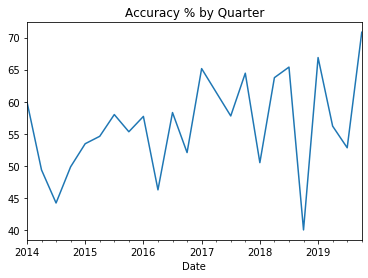

In [88]:
# Chart the accuracy over time on a quarterly basis
quarterly_metrics["accuracy"].plot(title="Accuracy % by Quarter")

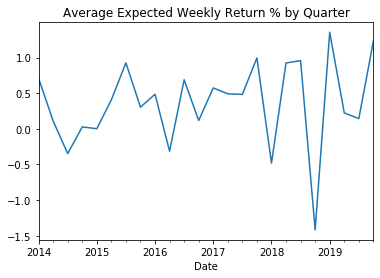

In [90]:
# Chart the expected_weekly_return_% over time on a quarterly basis
quarterly_metrics["expected_weekly_return_%"].plot(title="Average Expected Weekly Return % by Quarter")